In [1]:
#NSS

from metrics import NSS, CC, SIM


In [2]:
#| hide
import os
import torch

os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"

ngpu = torch.cuda.device_count()
for gpu_id in range(ngpu):
    gpu = torch.cuda.get_device_name(gpu_id)
    print(f"GPU:{gpu_id} {gpu}")



GPU:0 NVIDIA GeForce RTX 2080 Ti
GPU:1 NVIDIA GeForce RTX 2080 Ti


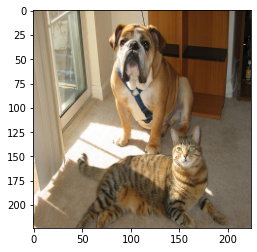

In [3]:
#| export
import matplotlib.pyplot as plt
from PIL import Image

#nss case 1: max nss

#| hide
os.chdir("/project/validating_attribution_techniques/")

current_dir = os.getcwd()
img_rel_path = "commons/examples/input.png"
img_full_path = os.path.join(current_dir, img_rel_path)


image = Image.open(img_full_path)
plt.imshow(image)

In [4]:
#| hide
%pip install git+https://github.com/facebookresearch/segment-anything.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-bjnq1ci0
  Running command git clone -q https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-bjnq1ci0
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
#| export
from segment_anything import SamPredictor, sam_model_registry

In [6]:
#| hide
# Source for the following functions: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [7]:
sam_model_full_path = os.path.join(current_dir, "abid/vendors/sam_vit_b_01ec64.pth")
sam = sam_model_registry["vit_b"](checkpoint=sam_model_full_path)
predictor = SamPredictor(sam)

In [8]:
import numpy as np

#| hide
predictor.set_image(np.array(image))

In [9]:
#| hide
input_point = np.array([[100, 50]])
input_label = np.array([1])

masks, scores, logits = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)

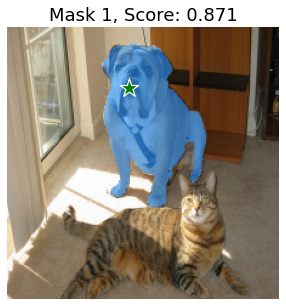

In [10]:
#| hide
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()
    break

In [11]:
#| hide
mask = masks[0]

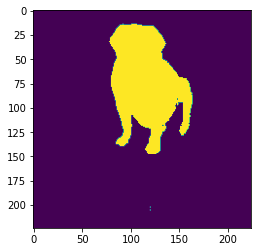

In [12]:
#| hide
mask.shape
plt.imshow(mask)

print(mask)

NSS: Normalized scanpath saliency

# Normalized Scanpath Saliency

Location metric with an ability to account for false positives.

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import (polygon, disk)

# Case1: Location dependence

Two exactly same saliency maps (same location of salient ares)

Result: maximum NSS

NSS SCORE:  1.2768434864997555


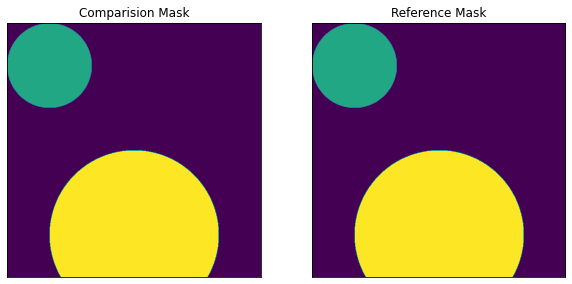

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

rr, cc = disk((500, 300), 200, shape=img.shape)
rr_1, cc_1 = disk((100, 100), 100, shape=img.shape)
img[rr, cc] = 1
img[rr_1, cc_1] = 0.6
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 300), 200, shape=img.shape)
rr_1, cc_1 = disk((100, 100), 100, shape=img.shape)
img_2[rr,cc] = 1
img_2[rr_1, cc_1] = 0.6
mask_2 = img_2
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('Comparision Mask')
ax2.set_title('Reference Mask')

print('NSS SCORE: ',NSS(mask_1, mask_2))

# Case 2: Different saliency location from ground truth

NSS SCORE:  0.9776938569400325


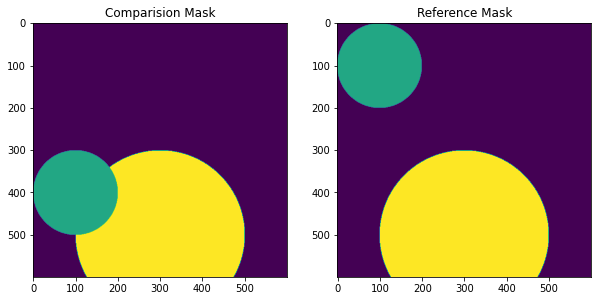

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

rr, cc = disk((500, 300), 200, shape=img.shape)
rr_1, cc_1 = disk((400, 100), 100, shape=img.shape)
img[rr, cc] = 1
img[rr_1, cc_1] = 0.6
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 300), 200, shape=img.shape)
rr_1, cc_1 = disk((100, 100), 100, shape=img.shape)
img_2[rr,cc] = 1
img_2[rr_1, cc_1] = 0.6
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('Comparision Mask')
ax2.set_title('Reference Mask')

print('NSS SCORE: ',NSS(mask_1, mask_2))

# Case 3: Too much difference

NSS SCORE:  -0.6992103742697147


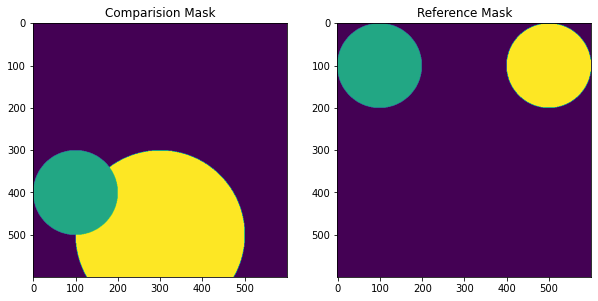

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

rr, cc = disk((500, 300), 200, shape=img.shape)
rr_1, cc_1 = disk((400, 100), 100, shape=img.shape)
img[rr, cc] = 1
img[rr_1, cc_1] = 0.6
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((100, 500), 100, shape=img.shape)
rr_1, cc_1 = disk((100, 100), 100, shape=img.shape)
img_2[rr,cc] = 1
img_2[rr_1, cc_1] = 0.6
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('Comparision Mask')
ax2.set_title('Reference Mask')

print('NSS SCORE: ',NSS(mask_1, mask_2))

# Case 4: Concept of saliency threshold in calculating NSS

(Comaparision image does not capture all of the salient area)

2.8206808608205667


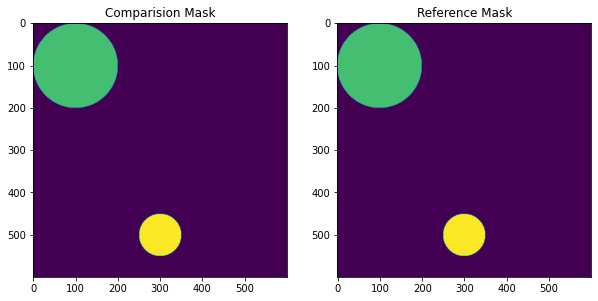

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

rr, cc = disk((500, 300), 50, shape=img.shape)
rr_1, cc_1 = disk((100, 100), 100, shape=img.shape)
img[rr, cc] = 1
img[rr_1, cc_1] = 0.7
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 300), 50, shape=img.shape)
rr_1, cc_1 = disk((100, 100), 100, shape=img.shape)
img_2[rr,cc] = 1
img_2[rr_1, cc_1] = 0.7
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('Comparision Mask')
ax2.set_title('Reference Mask')

print(NSS(mask_1, mask_2))

1.6917396866880803


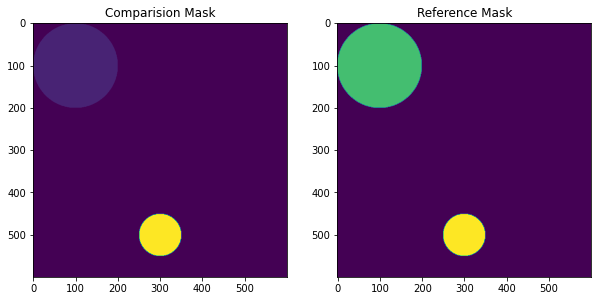

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

rr, cc = disk((500, 300), 50, shape=img.shape)
rr_1, cc_1 = disk((100, 100), 100, shape=img.shape)
img[rr, cc] = 1
img[rr_1, cc_1] = 0.1
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 300), 50, shape=img.shape)
rr_1, cc_1 = disk((100, 100), 100, shape=img.shape)
img_2[rr,cc] = 1
img_2[rr_1, cc_1] = 0.7
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('Comparision Mask')
ax2.set_title('Reference Mask')

print(NSS(mask_1, mask_2))

# Case 4: Case with false positives

(Penalized if it Captures more than the salient area)

1.3137458398635753


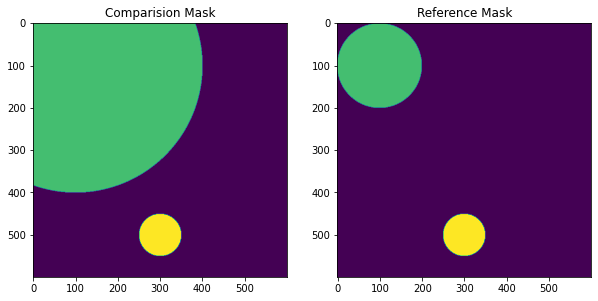

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

rr, cc = disk((500, 300), 50, shape=img.shape)
rr_1, cc_1 = disk((100, 100), 300, shape=img.shape)
img[rr, cc] = 1
img[rr_1, cc_1] = 0.7
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 300), 50, shape=img.shape)
rr_1, cc_1 = disk((100, 100), 100, shape=img.shape)
img_2[rr,cc] = 1
img_2[rr_1, cc_1] = 0.7
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('Comparision Mask')
ax2.set_title('Reference Mask')

print(NSS(mask_1, mask_2))

# Measuring Histogram intersection of distributions

1.0


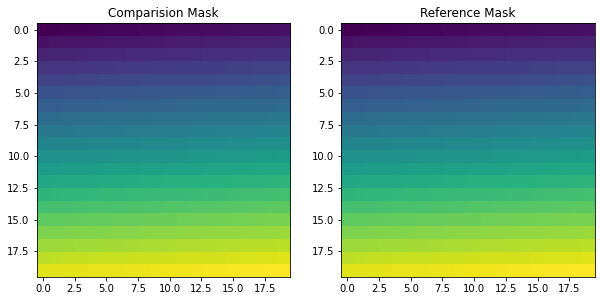

In [20]:
mask_1 = np.arange(400).reshape(20,20)
mask_2 = np.arange(400)
mask_2 = mask_2.reshape((20,20))

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

ax1.imshow(mask_1)
ax2.imshow(mask_2)

ax1.set_title('Comparision Mask')
ax2.set_title('Reference Mask')

print(SIM(mask_1, mask_2))

1.0


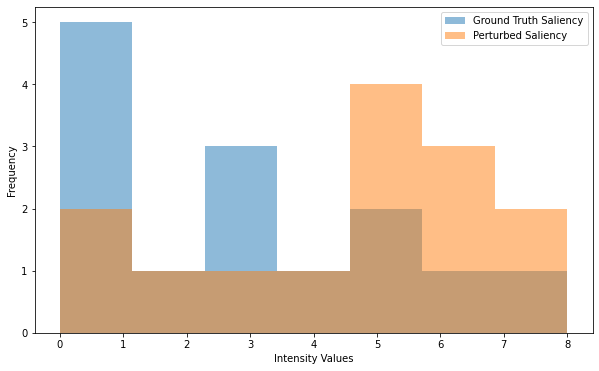

In [21]:
saliency_map1 = np.array([1,2,3,3,3,4,5,5,6,7,1,1,1,1])
saliency_map2 = np.array([1,2,3,4,5,5,5,5,6,6,6,7,7,1])

fig= plt.subplots(ncols=1, nrows=1, figsize=(10, 6))

hist1, bins1 = np.histogram(saliency_map1, bins=7, range=(0, 8))
hist2, bins2 = np.histogram(saliency_map2, bins=7, range=(0, 8))

    # Plot the histograms
plt.hist(bins1[:-1], bins1, weights=hist1, alpha=0.5, label='Ground Truth Saliency')
plt.hist(bins2[:-1], bins2, weights=hist2, alpha=0.5, label='Perturbed Saliency')
plt.xlabel('Intensity Values')
plt.ylabel('Frequency')
plt.legend()


print(SIM(mask_1, mask_2))

1.2000000000000002


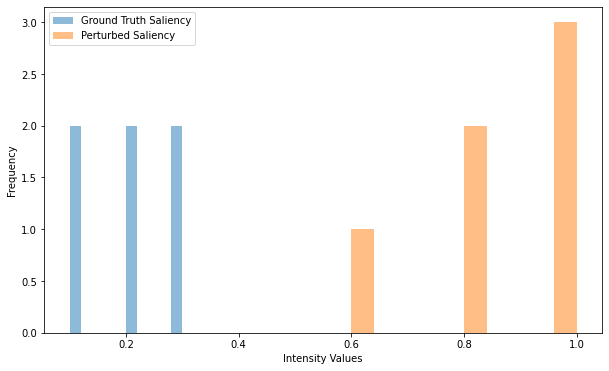

In [22]:
saliency_map_3 = np.array([0.1,0.1, 0.2,0.2,0.3,0.3,])
saliency_map_4 = np.array([0.6,0.8,0.8, 1,1,1 ])


fig= plt.subplots(ncols=1, nrows=1, figsize=(10, 6))

hist1, bins1 = np.histogram(saliency_map_3)
hist2, bins2 = np.histogram(saliency_map_4)

plt.hist(bins1[:-1], bins1, weights=hist1, alpha=0.5, label='Ground Truth Saliency')
plt.hist(bins2[:-1], bins2, weights=hist2, alpha=0.5, label='Perturbed Saliency')

plt.xlabel('Intensity Values')
plt.ylabel('Frequency')
plt.legend()

print(np.sum(np.minimum(saliency_map_3, saliency_map_4)))

0.4987468671679197


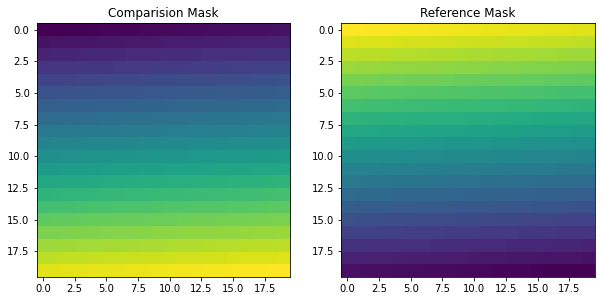

In [23]:
mask_1 = np.arange(400).reshape(20,20)
mask_2 = np.arange(400)
mask_2[::-1].sort()
mask_2 = mask_2.reshape((20,20))

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

ax1.imshow(mask_1)
ax2.imshow(mask_2)

ax1.set_title('Comparision Mask')
ax2.set_title('Reference Mask')

print(SIM(mask_1, mask_2))

In [24]:
mask_1 = np.arange(0,400).reshape(20,20)
mask_2 = np.arange(100,800)
mask_2[::-1].sort()
mask_2 = mask_2.reshape((20,20))

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

ax1.imshow(mask_1)
ax2.imshow(mask_2)

ax1.set_title('Comparision Mask')
ax2.set_title('Reference Mask')

print(SIM(mask_1, mask_2))

ValueError: cannot reshape array of size 700 into shape (20,20)

In [ ]:
mask_1 = np.arange(400).reshape(20,20)
mask_2 = np.arange(400)
mask_2[::-1].sort()
mask_2 = mask_2.reshape((20,20))

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

ax1.imshow(mask_1)
ax2.imshow(mask_2)

ax1.set_title('Comparision Mask')
ax2.set_title('Reference Mask')

print(SIM(mask_1, mask_2))

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage.draw import (polygon, disk)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

# fill circle
rr, cc = disk((500, 300), 100, shape=img.shape)
img[rr, cc] = 1
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 300), 200, shape=img.shape)
img_2[rr,cc] = 1
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('No anti-aliasing')
ax1.axis('off')

print(SIM(mask_1, mask_2))

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage.draw import (polygon, disk)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

# fill circle
rr, cc = disk((500, 300), 200, shape=img.shape)
img[rr, cc] = 1
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 300), 100, shape=img.shape)
img_2[rr,cc] = 1
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('No anti-aliasing')
ax1.axis('off')

print(NSS(mask_1, mask_2))

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage.draw import (polygon, disk)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

# fill circle
rr, cc = disk((500, 300), 200, shape=img.shape)
img[rr, cc] = 1
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 300), 200, shape=img.shape)
img_2[rr,cc] = 1
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('No anti-aliasing')
ax1.axis('off')

print(NSS(mask_1, mask_2))

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage.draw import (polygon, disk)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

# fill circle
rr, cc = disk((500, 300), 200, shape=img.shape)
img[rr, cc] = 1
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 300), 200, shape=img.shape)
img_2[rr,cc] = 1
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('No anti-aliasing')
ax1.axis('off')

print(NSS(mask_1, mask_2))

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage.draw import (polygon, disk)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

# fill circle
rr, cc = disk((200, 300), 200, shape=img.shape)
img[rr, cc] = 1
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((50, 300), 50, shape=img.shape)
img_2[rr,cc] = 1
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('No anti-aliasing')
ax1.axis('off')

print(NSS(mask_1, mask_2))

In [ ]:
#case 3: false positives (comparision mask > ref mask)

In [ ]:
# case 4: ref mask > comparision mask (less score)

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage.draw import (polygon, disk)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

# fill circle
rr, cc = disk((100, 100), 100, shape=img.shape)
img[rr, cc] = 1
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 300), 200, shape=img.shape)
img_2[rr,cc] = 1
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('No anti-aliasing')
ax1.axis('off')

print(SIM(mask_1, mask_2))


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage.draw import (polygon, disk)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

# fill circle
rr, cc = disk((100, 100), 400, shape=img.shape)
img[rr, cc] = 1
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 300), 200, shape=img.shape)
img_2[rr,cc] = 1
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('No anti-aliasing')
ax1.axis('off')

print(SIM(mask_1, mask_2))

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

# fill circle
rr, cc = disk((100, 100), 100, shape=img.shape)
img[rr, cc] = 1
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((100, 100), 200, shape=img.shape)
img_2[rr,cc] = 1
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('No anti-aliasing')
ax1.axis('off')

print(SIM(mask_1, mask_2))

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

# fill circle
rr, cc = disk((500, 100), 200, shape=img.shape)
img[rr, cc] = 1
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 400), 200, shape=img.shape)
img_2[rr,cc] = 1
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('No anti-aliasing')
ax1.axis('off')

print(SIM(mask_1, mask_2))

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

# fill circle
rr, cc = disk((500, 400), 200, shape=img.shape)
img[rr, cc] = 1
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 400), 200, shape=img.shape)
rr_1, cc_1 = disk((200, 100), 200, shape=img.shape)

img_2[rr,cc] = 1
img_2[rr_1,cc_1] = 0.7
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('No anti-aliasing')
ax1.axis('off')

print(SIM(mask_1, mask_2))

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

# fill circle
rr, cc = disk((500, 400), 200, shape=img.shape)
img[rr, cc] = 1
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 400), 200, shape=img.shape)
rr_1, cc_1 = disk((200, 100), 200, shape=img.shape)

img_2[rr,cc] = 1
img_2[rr_1,cc_1] = 0.2
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('No anti-aliasing')
ax1.axis('off')

print(SIM(mask_1, mask_2))

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

# fill circle
rr, cc = disk((500, 400), 200, shape=img.shape)
rr_1, cc_1 = disk((200, 100), 200, shape=img.shape)
img[rr, cc] = 1
img[rr_1,cc_1] = 0.8
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 400), 200, shape=img.shape)
rr_1, cc_1 = disk((200, 100), 200, shape=img.shape)

img_2[rr, cc] = 20
img_2[rr_1,cc_1] = 0.8
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('No anti-aliasing')
ax1.axis('off')

print(SIM(mask_1, mask_2))

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

img = np.zeros((600, 600), dtype=np.double)

# fill circle
rr, cc = disk((500, 400), 200, shape=img.shape)
rr_1, cc_1 = disk((200, 100), 200, shape=img.shape)
img[rr, cc] = 1
img[rr_1,cc_1] = 0.8
mask_1 = img

img_2 = np.zeros((600, 600), dtype=np.double)
rr, cc = disk((500, 400), 200, shape=img.shape)

img_2[rr,cc] = 1
mask_2 = img_2

ax1.imshow(img)
ax2.imshow(img_2)
ax1.set_title('No anti-aliasing')
ax1.axis('off')

print(SIM(mask_1, mask_2))

Properties of NSS:

1. Location intersection